In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import date, timedelta
from sklearn.metrics import mean_squared_error
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

In [2]:
df = pd.read_csv('Dataset_combined/Total_dataset.csv')

In [3]:
df.drop('Unnamed: 0',axis=1,inplace=True)
df

,Timestamp,W
0,2013-05-24 00:00:00,282.744995
1,2013-05-24 00:00:01,288.757996
2,2013-05-24 00:00:02,288.757996
3,2013-05-24 00:00:03,297.394012
4,2013-05-24 00:00:04,303.722992
...,...,...
4391054,2013-08-05 15:33:10,711.764891
4391055,2013-08-05 15:33:11,711.764891
4391056,2013-08-05 15:33:12,711.911695
4391057,2013-08-05 15:33:15,712.182676


In [4]:
df['TIMESTAMP']=pd.to_datetime(df['Timestamp'])


In [5]:
df['Timestamp']=df['TIMESTAMP']
df.drop('TIMESTAMP',axis=1,inplace=True)

In [6]:
#df.drop(['A','PF','f','VA','VAR','VLN'],axis=1,inplace=True)
#df.drop('VLN',axis=1,inplace=True)
df.shape

(4391059, 2)

In [7]:
df = df.set_index('Timestamp')

In [8]:
df = df.resample('min').mean()

In [9]:
df

,W
Timestamp,
2013-05-24 00:00:00,285.566998
2013-05-24 00:01:00,284.513632
2013-05-24 00:02:00,283.382776
2013-05-24 00:03:00,419.192352
2013-05-24 00:04:00,418.725591
...,...
2013-08-05 15:29:00,507.936435
2013-08-05 15:30:00,537.798291
2013-08-05 15:31:00,636.553161


In [10]:
df = df.reset_index()

In [11]:
df.shape

(106054, 2)

In [12]:
df['KW'] = df['W']/1000

In [13]:
df.drop('W',axis=1,inplace=True)

In [14]:
df['Day']=pd.to_datetime(df['Timestamp']).dt.dayofweek
df

,Timestamp,KW,Day
0,2013-05-24 00:00:00,0.285567,4
1,2013-05-24 00:01:00,0.284514,4
2,2013-05-24 00:02:00,0.283383,4
3,2013-05-24 00:03:00,0.419192,4
4,2013-05-24 00:04:00,0.418726,4
...,...,...,...
106049,2013-08-05 15:29:00,0.507936,0
106050,2013-08-05 15:30:00,0.537798,0
106051,2013-08-05 15:31:00,0.636553,0
106052,2013-08-05 15:32:00,0.694195,0


In [15]:
df['Hour']=pd.to_datetime(df['Timestamp']).dt.hour
df['Minute']=pd.to_datetime(df['Timestamp']).dt.minute
#df['Seconds']=pd.to_datetime(df['timestamp']).dt.second
df.drop('Timestamp',axis=1,inplace=True)

In [16]:
df.iloc[96480:,:]

,KW,Day,Hour,Minute
96480,0.400066,1,0,0
96481,0.399054,1,0,1
96482,0.396299,1,0,2
96483,0.384728,1,0,3
96484,0.384186,1,0,4
...,...,...,...,...
106049,0.507936,0,15,29
106050,0.537798,0,15,30
106051,0.636553,0,15,31
106052,0.694195,0,15,32


In [17]:
df['KW']=pd.to_numeric(df['KW'], errors='coerce')

In [18]:
df['KW'].dtype

dtype('float64')

In [19]:
scaler = MinMaxScaler(feature_range=(0,1))
df_1=scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_1,columns=df.columns)
df_scaled

,KW,Day,Hour,Minute
0,0.023085,0.666667,0.000000,0.000000
1,0.022962,0.666667,0.000000,0.016949
2,0.022829,0.666667,0.000000,0.033898
3,0.038796,0.666667,0.000000,0.050847
4,0.038741,0.666667,0.000000,0.067797
...,...,...,...,...
106049,0.049229,0.000000,0.652174,0.491525
106050,0.052740,0.000000,0.652174,0.508475
106051,0.064351,0.000000,0.652174,0.525424
106052,0.071127,0.000000,0.652174,0.542373


In [20]:
X=df_scaled.drop('KW',axis=1)
y=df_scaled['KW']

In [21]:
X = np.asarray(X).astype(np.float32)
y= np.asarray(y).astype(np.float32)

In [26]:
df1 = df[df.isna().any(axis=1)]

In [27]:
df1

,KW,Day,Hour,Minute
104,NaN,4,1,44
105,NaN,4,1,45
106,NaN,4,1,46
107,NaN,4,1,47
108,NaN,4,1,48
...,...,...,...,...
104087,NaN,6,6,47
104088,NaN,6,6,48
104089,NaN,6,6,49
104753,NaN,6,17,53


In [28]:
df_scaled.dropna(inplace=True)

In [29]:
df_scaled.isnull().sum()

KW        0
Day       0
Hour      0
Minute    0
dtype: int64

In [30]:
df_scaled.shape

(99486, 4)

In [31]:
df_scaled.iloc[90193:,:]

,KW,Day,Hour,Minute
96480,0.036547,0.166667,0.000000,0.000000
96481,0.036428,0.166667,0.000000,0.016949
96482,0.036104,0.166667,0.000000,0.033898
96483,0.034744,0.166667,0.000000,0.050847
96484,0.034680,0.166667,0.000000,0.067797
...,...,...,...,...
106049,0.049229,0.000000,0.652174,0.491525
106050,0.052740,0.000000,0.652174,0.508475
106051,0.064351,0.000000,0.652174,0.525424
106052,0.071127,0.000000,0.652174,0.542373


In [32]:
training_size=int(len(df_scaled)*0.906589872)
test_size=len(df_scaled)-training_size
X_train,y_train,X_test,y_test=df_scaled.iloc[0:training_size,1:4],df_scaled.iloc[0:training_size,0],df_scaled.iloc[training_size:len(df_scaled),1:4],df_scaled.iloc[training_size:len(df_scaled),0]
X_train=X_train.to_numpy()
y_train=y_train.to_numpy()
X_test=X_test.to_numpy()
y_test=y_test.to_numpy()
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(90193, 3) (90193,) (9293, 3) (9293,)


In [33]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test  = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
#y_train = y_train.reshape(-1, 1, 1)
#y_test = y_test.reshape(-1, 1, 1)

In [34]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(1,3)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
_________________________________________________________________


In [35]:
model_history=model.fit(X_train, y_train, batch_size = 256,epochs = 50, validation_data=(X_test,y_test),verbose=1)

Epoch 1/50
353/353 [==============================] - 12s 11ms/step - loss: 0.0145 - val_loss: 0.0097
Epoch 2/50
353/353 [==============================] - 3s 8ms/step - loss: 0.0142 - val_loss: 0.0097
Epoch 3/50
353/353 [==============================] - 3s 8ms/step - loss: 0.0142 - val_loss: 0.0098
Epoch 4/50
353/353 [==============================] - 3s 8ms/step - loss: 0.0141 - val_loss: 0.0102
Epoch 5/50
353/353 [==============================] - 2s 7ms/step - loss: 0.0139 - val_loss: 0.0092
Epoch 6/50
353/353 [==============================] - 2s 7ms/step - loss: 0.0134 - val_loss: 0.0091
Epoch 7/50
353/353 [==============================] - 2s 7ms/step - loss: 0.0120 - val_loss: 0.0082
Epoch 8/50
353/353 [==============================] - 3s 7ms/step - loss: 0.0115 - val_loss: 0.0081
Epoch 9/50
353/353 [==============================] - 3s 7ms/step - loss: 0.0112 - val_loss: 0.0078
Epoch 10/50
353/353 [==============================] - 3s 7ms/step - loss: 0.0107 - val_loss: 0.00

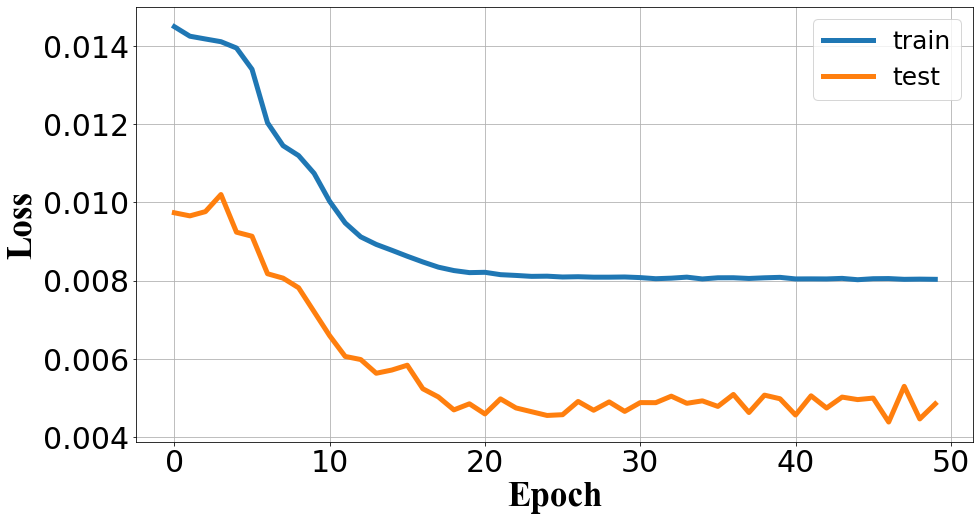

In [36]:
plt.figure(figsize=(15,8))
plt.plot(model_history.history['loss'],linewidth=5)
plt.plot(model_history.history['val_loss'],linewidth=5)
#plt.title('Model loss',fontsize=35,fontname="Times New Roman",fontweight="bold")
plt.ylabel('Loss',fontsize=35,fontname="Times New Roman",fontweight="bold")
plt.xlabel('Epoch',fontsize=35,fontname="Times New Roman",fontweight="bold")
plt.legend(['train', 'test'], loc='upper right',fontsize=25)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.grid()
plt.savefig('H_Model.png')
plt.savefig('H_Model.pdf')
plt.show()

In [37]:
size = df.shape[1]

In [38]:
size

4

In [39]:
X_test.shape

(9293, 1, 3)

In [40]:
yhat = model.predict(X_test)

In [41]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

In [42]:
inv_yhat = np.concatenate((yhat, X_test[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
inv_yhat.shape

(9293,)

In [43]:
# invert scaling for actual
y_test = y_test.reshape((len(y_test), 1))
inv_y = np.concatenate((y_test, X_test[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
inv_y.shape

(9293,)

In [44]:
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.593


In [45]:
from sklearn.metrics import mean_absolute_percentage_error

In [47]:
mape = mean_absolute_percentage_error(inv_y,inv_yhat)

In [48]:
mape

0.6083841931408592

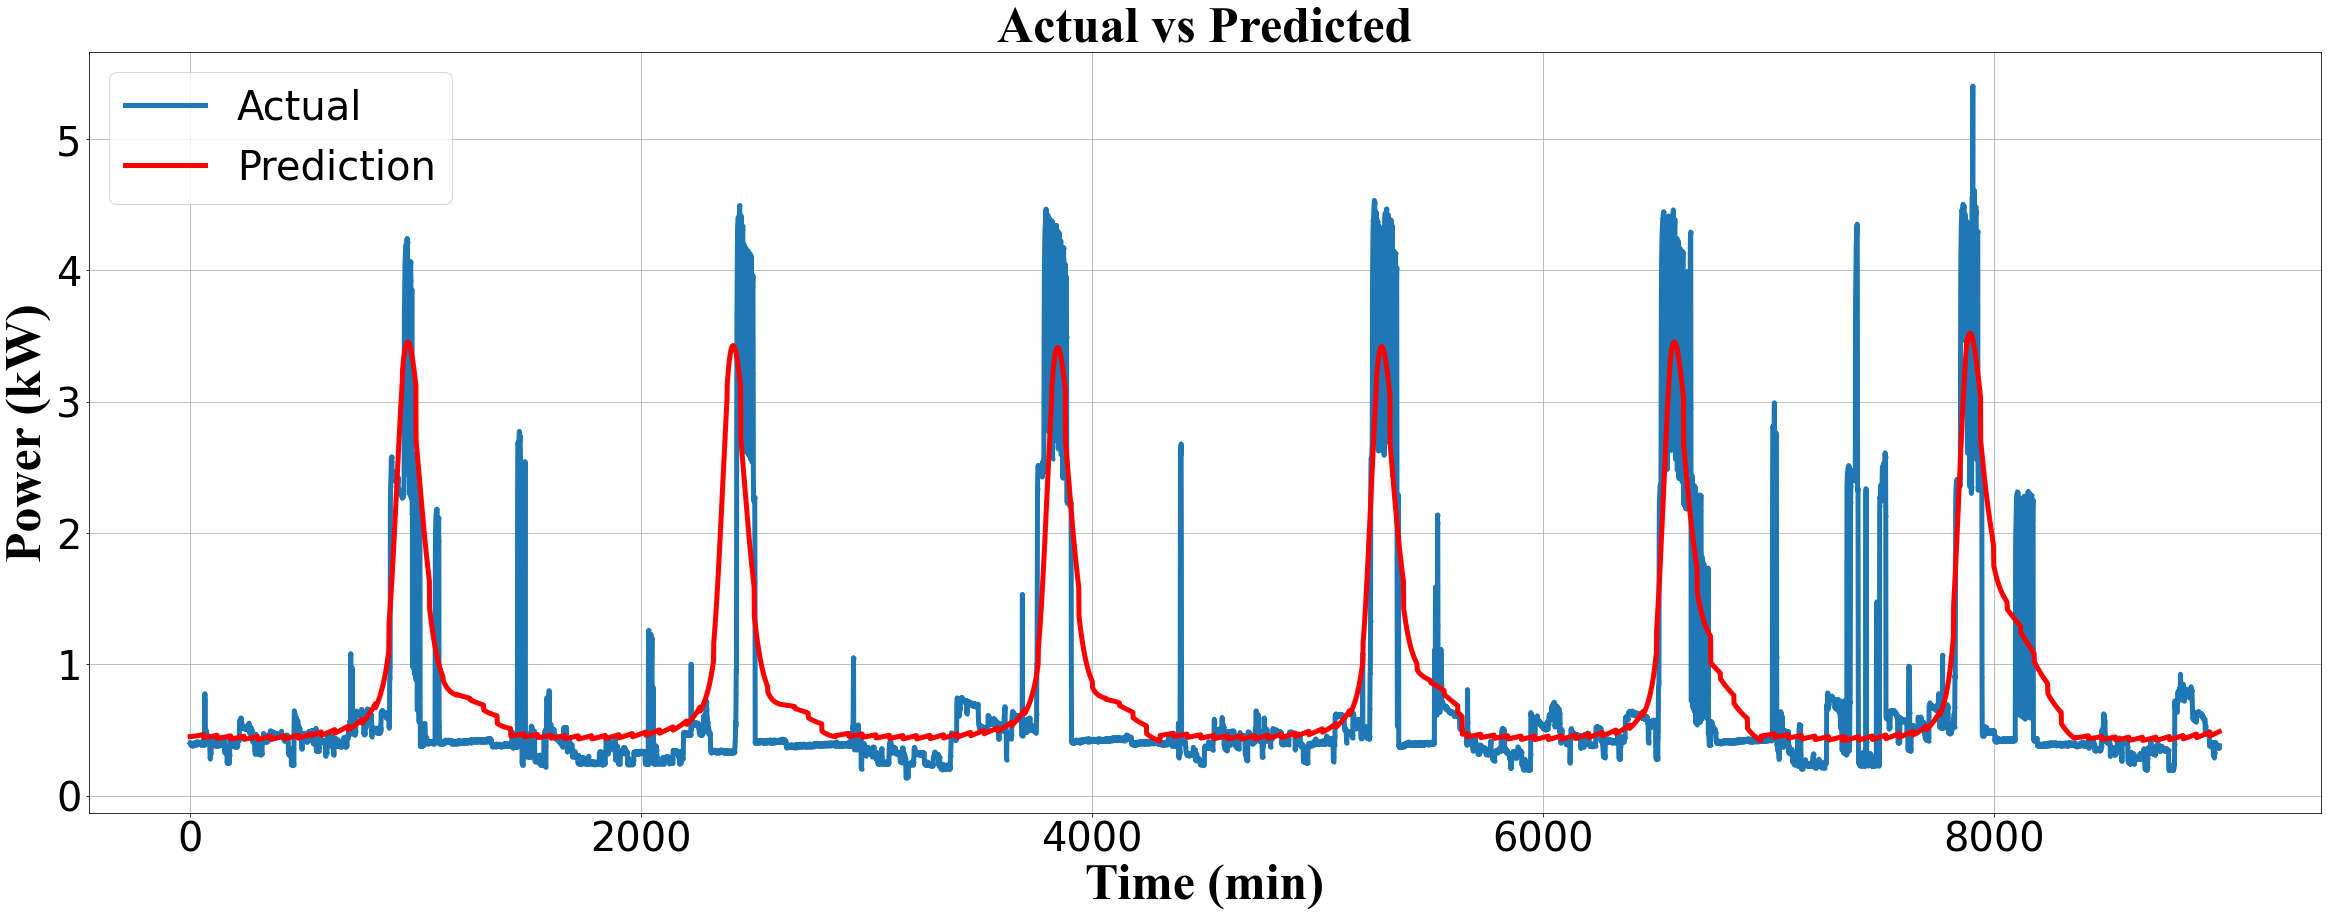

In [85]:
y=0
for i in range(9000,10080,9000):
    aa=[x for x in range(y,i)]
    plt.figure(figsize=(40,14)) 
    plt.plot(aa, inv_y[y:i], marker='.', label="Actual",linewidth=5 )
    plt.plot(aa, inv_yhat[y:i], 'r', label="Prediction",linewidth=5)
    y = i
    plt.title('Actual vs Predicted', size=50,fontname="Times New Roman",fontweight="bold")
    plt.ylabel('Power (kW)', size=50,fontname="Times New Roman",fontweight="bold")
    plt.xlabel('Time (min)', size=50,fontname="Times New Roman",fontweight="bold")
    plt.legend(fontsize=40)
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    plt.grid()
    plt.savefig('H_pred.pdf')
    plt.savefig('H_pred.png')
    plt.show()

In [42]:
inv_y.sum()/60

108.50449679623372

In [43]:
inv_yhat.sum()/60

124.82220724340463

In [44]:
X_test

array([[0.16666667, 0.        , 0.        ],
       [0.16666667, 0.        , 0.01694915],
       [0.16666667, 0.        , 0.03389831],
       ...,
       [0.        , 0.65217391, 0.52542373],
       [0.        , 0.65217391, 0.54237288],
       [0.        , 0.65217391, 0.55932203]])

In [45]:
actual = pd.DataFrame(inv_y,columns=['Actual'])

In [46]:
predict = pd.DataFrame(inv_yhat,columns=['Predict'])

In [47]:
predict

,Predict
0,0.448543
1,0.448640
2,0.448747
3,0.448864
4,0.448990
...,...
9288,2.553568
9289,2.586432
9290,2.619200
9291,2.651846


In [48]:
actual

,Actual
0,0.400066
1,0.399054
2,0.396299
3,0.384728
4,0.384186
...,...
9288,0.507936
9289,0.537798
9290,0.636553
9291,0.694195


In [49]:
df2 = df.iloc[90718:,:]

In [50]:
df2.shape

(15336, 4)